In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
color_dict = {
    "Eggshell": "#f4f1de",
    "Burnt sienna": "#e07a5f",
    "Delft Blue": "#3d405b",
    "Cambridge blue": "#81b29a",
    "Sunset": "#f2cc8f",
}

# Use LaTeX fonts for a professional look
plt.rcParams.update(
    {
        "text.usetex": True,  # Use LaTeX for text rendering
        "font.family": "serif",  # Use serif fonts
    }
)

# Set seaborn style for better aesthetics
# sns.set_style("whitegrid")

## Extract across Languages

In [2]:
name_mapping = {
    'random': 'Random',
    'irt': 'IRT',
    'rc': 'Representation Clustering',
    'pirt': 'p-IRT',
    'gpirt': 'gp-IRT',
    'mpirt': 'mp-IRT',
    'gmpirt': 'gmp-IRT',
}

In [3]:
# ----------------------------------------------------------------------
# Read data
# ------------------------------------------------------------------------
# Example file names; adjust as needed
df_all = pd.read_csv("data/estimate_languages.csv")

# rename column estimate_method to estimate_method
df_all = df_all.rename(columns={"estimate_method": "estimate_method"})

In [4]:
# rename 
df_all['estimate_method'] = df_all['estimate_method'].map(name_mapping)

df_all.dropna(inplace=True)


In [5]:
df_all

,lang,n_samples,accuracy,estimate_method,iter,diff
0,dutch,20,0.382108,IRT,5,0.006823
1,german,50,0.385140,IRT,6,0.001516
2,spanish,10,0.570887,IRT,7,0.025019
3,italian,100,0.506444,IRT,4,0.040182
4,german,50,0.278999,IRT,7,0.104625
...,...,...,...,...,...,...
2095,spanish,20,0.450000,Random,3,0.095868
2096,spanish,20,0.500000,Random,4,0.045868
2097,spanish,20,0.500000,Random,5,0.045868
2098,spanish,20,0.700000,Random,6,0.154132


estimate_methods in summary: ['IRT' 'Random' 'Representation Clustering' 'gmp-IRT' 'gp-IRT' 'mp-IRT'
 'p-IRT']


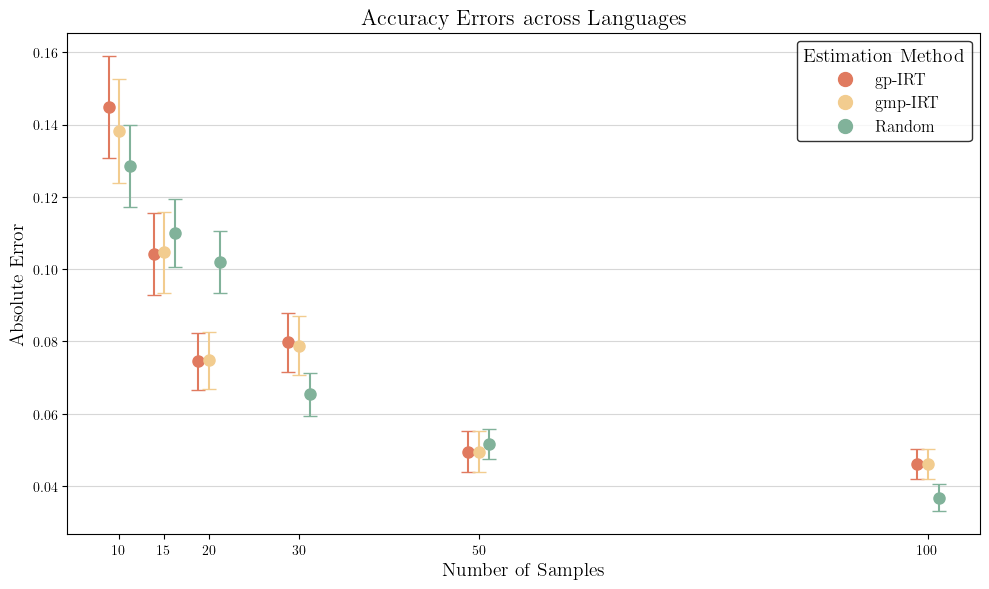

In [6]:
# Calculate the difference between true accuracy and estimated accuracy
# Calculate the difference between true accuracy and estimated accuracy

hue_order = ['gp-IRT', 'gmp-IRT', 'Random']

# Define colors for the different estimate_methods
palette = {
    "Random": color_dict["Cambridge blue"],
    "gp-IRT": color_dict["Burnt sienna"],
    "gmp-IRT": color_dict["Sunset"],
}

OFFSET = 1.2

estimated_acc_df = df_all.copy()

# Fixed x-offsets for each method
offsets = {hue: i * OFFSET - OFFSET for i, hue in enumerate(hue_order)}  # Evenly spaced offsets around 0

# Calculate mean and standard error for each combination of `n_samples` and `estimate_method` across all languages
summary = estimated_acc_df.groupby(['n_samples', 'estimate_method']).agg(
    mean_diff=('diff', 'mean'),
    se_diff=('diff', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Debugging: Check unique estimate_methods in summary
print("estimate_methods in summary:", summary['estimate_method'].unique())

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with error bars for each method
for j, m in enumerate(hue_order):
    subset = summary[summary['estimate_method'] == m]
    if subset.empty:  # Log if a subset is empty
        print(f"Warning: No data for estimate_method '{m}'")
        continue
    x_offset = offsets[m]  # Fixed offset based on method
    adjusted_x = subset['n_samples'] + x_offset
    ax.errorbar(adjusted_x, subset['mean_diff'], yerr=subset['se_diff'], fmt='o',
                label=m, color=palette[m], alpha=1., capsize=5, markersize=8)

# Set labels and title
ax.set_title('Accuracy Errors across Languages', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=14)
ax.set_xlabel('Number of Samples', fontsize=14)

# Set x ticks
ax.set_xticks(summary['n_samples'].unique())

# Customize legend
handles = [plt.Line2D([0], [0], marker='o', color=palette[t], linestyle='', markersize=10) for t in hue_order]
labels = hue_order
legend = ax.legend(handles, labels, title='Estimation Method', loc='best', fontsize=12, title_fontsize=14)
legend.get_frame().set_alpha(0.8)
legend.get_frame().set_linewidth(1.)
legend.get_frame().set_edgecolor('black')

# Add grid lines
ax.yaxis.grid(True, linestyle='-', alpha=0.5)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

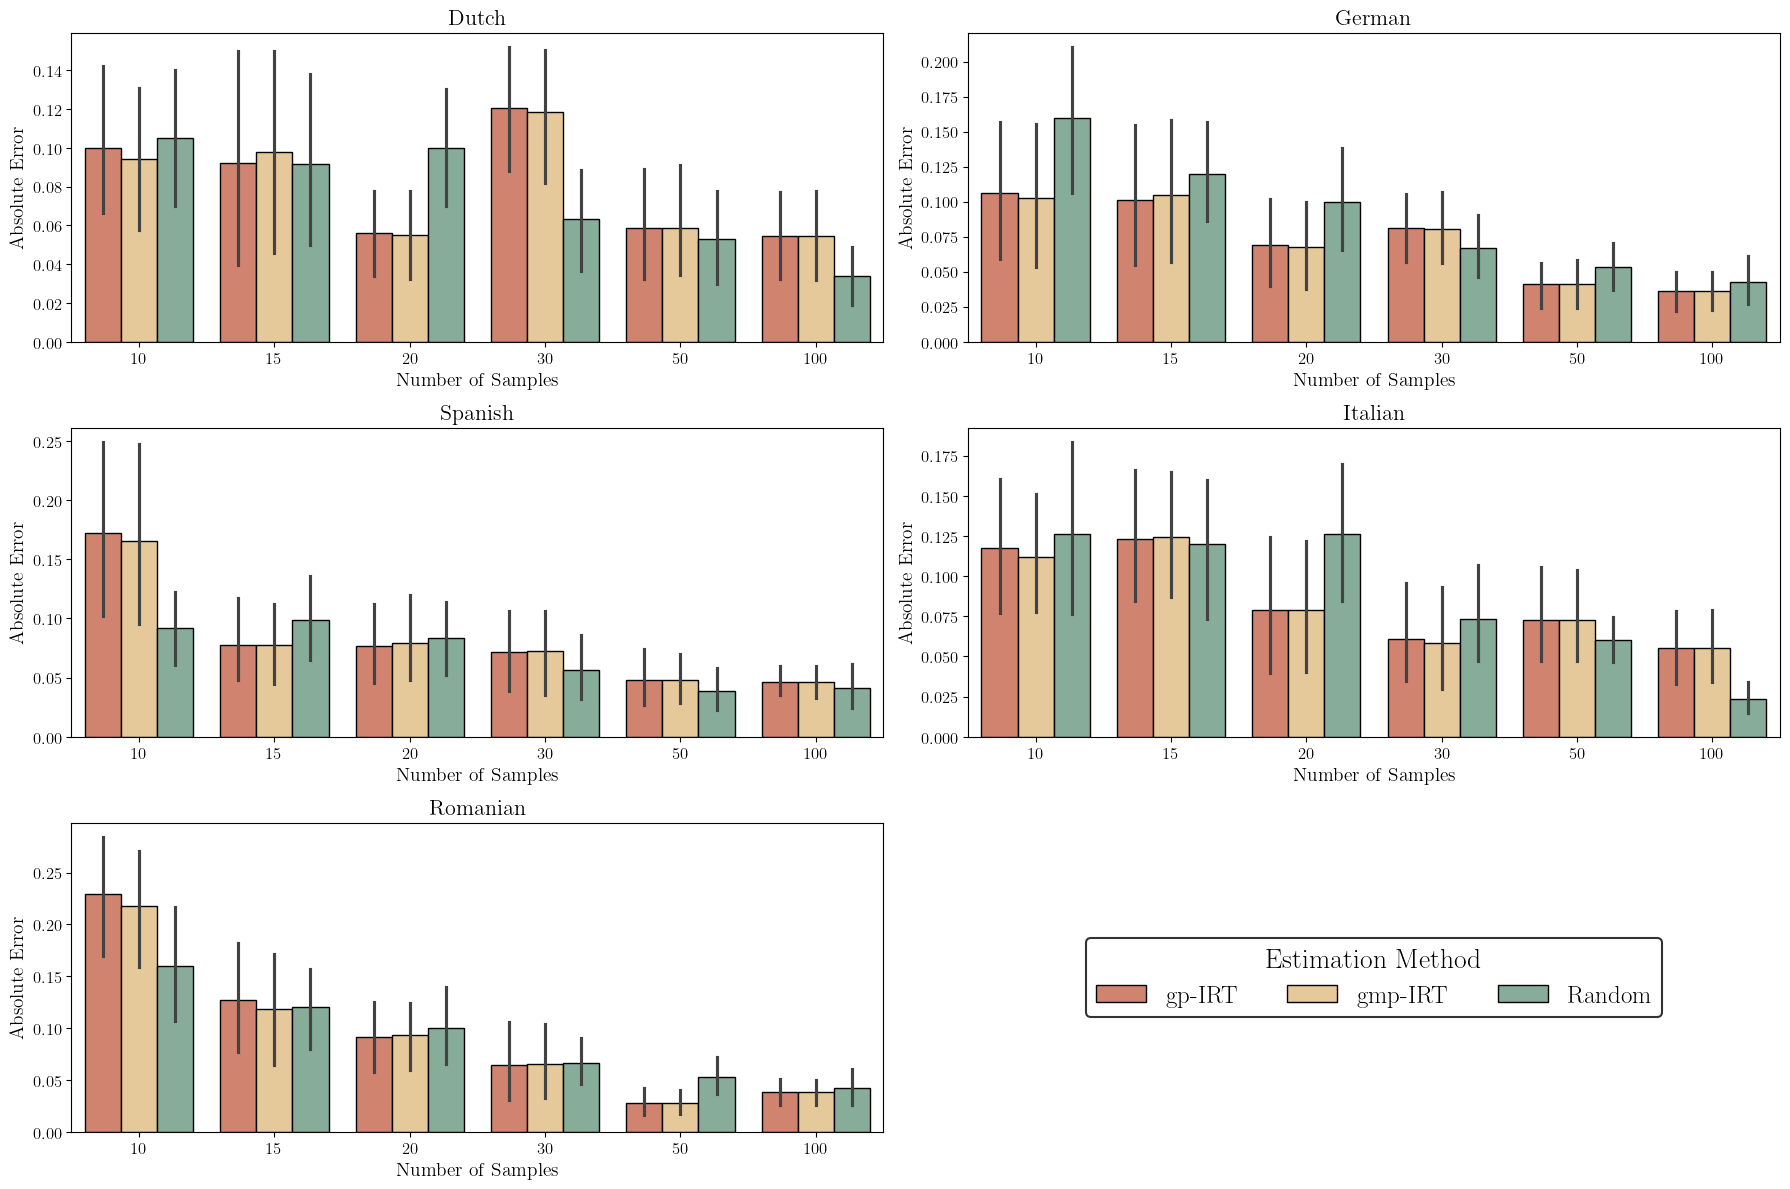

In [7]:
# Create a 3x2 layout of subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 12))  # 3 rows and 2 columns
axes = axes.flatten()  # Flatten the 2D array to easily iterate over it

langs = estimated_acc_df['lang'].unique()  # Get unique languages

# Iterate through each language and subplot axis
for i, lang in enumerate(langs):
    # Filter data for the specific language
    lang_data = estimated_acc_df[estimated_acc_df['lang'] == lang].copy()

    # Sort the data by hue_order to match the order of bars in the plot
    lang_data['estimate_method'] = pd.Categorical(lang_data['estimate_method'], categories=hue_order, ordered=True)
    lang_data = lang_data.sort_values('estimate_method')

    # Plot on the corresponding axis
    sns.barplot(
        x='n_samples', y='diff', hue='estimate_method', data=lang_data,
        palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=axes[i])

    # Set the title for each subplot
    axes[i].set_title(f"{lang}".casefold().capitalize())

    # set font size for title
    axes[i].title.set_fontsize(16)

    # hide legend
    axes[i].get_legend().remove()

    # set y title to 'Absolute Error'
    axes[i].set_ylabel('Absolute Error')

    # set x title to 'Number of Samples'
    axes[i].set_xlabel('Number of Samples')

    # set font size for x and y labels
    axes[i].xaxis.label.set_fontsize(14)
    axes[i].yaxis.label.set_fontsize(14)

    # set font size for x and y ticks
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

# Add the legend to the last subplot
axes[-1].axis('off')  # Turn off the axis for the empty subplot
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot

# Increase legend size by adjusting font size and label spacing
legend = axes[-1].legend(handles, labels, title='Estimation Method', loc='center', ncol=4, fontsize=18, title_fontsize=20)

# Optionally, increase the border and shadow of the legend for better visibility
legend.get_frame().set_alpha(0.8)  # Set transparency
legend.get_frame().set_linewidth(1.5)  # Set border linewidth
legend.get_frame().set_edgecolor('black')  # Set border color

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()


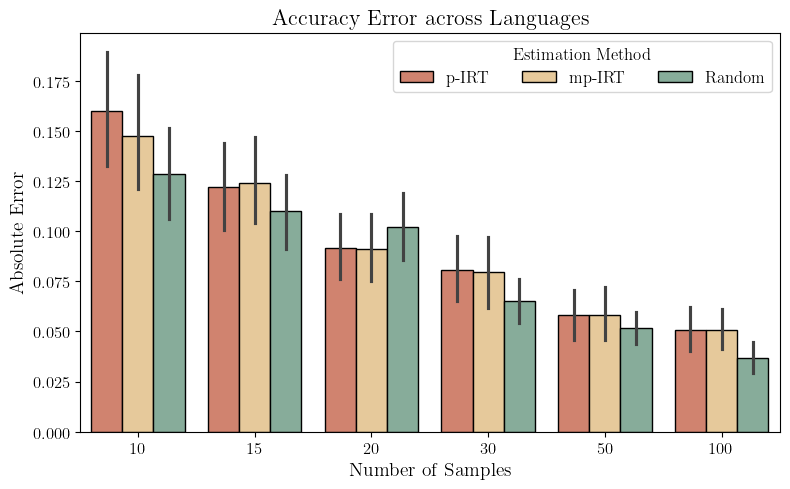

In [8]:
hue_order = ['p-IRT', 'mp-IRT', 'Random']

palette = {
    "Random": color_dict["Cambridge blue"],
    "p-IRT": color_dict["Burnt sienna"],
    "mp-IRT": color_dict["Sunset"],
}

langs = estimated_acc_df['lang'].unique()

# Create a 3x2 layout of subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # 3 rows and 2 columns

# Iterate through each language and subplot axis
# Filter data for the specific language
lang_data = estimated_acc_df.copy()

# Sort the data by hue_order to match the order of bars in the plot
lang_data['estimate_method'] = pd.Categorical(lang_data['estimate_method'], categories=hue_order, ordered=True)
lang_data = lang_data.sort_values('estimate_method')

# rename estimate_method column to estimate_method
lang_data.rename(columns={'estimate_method': 'estimate_method'}, inplace=True)
lang_data.to_csv(f"estimate_languages.csv", index=False)

# Plot on the corresponding axis
sns.barplot(
    x='n_samples', y='diff', hue='estimate_method', data=lang_data,
    palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=ax)

# Set the title for each subplot
ax.set_title(f"Accuracy Error across Languages")

# set font size for title
ax.title.set_fontsize(16)

# hide legend
ax.get_legend().remove()

# set y title to 'Absolute Error'
ax.set_ylabel('Absolute Error')

# set x title to 'Number of Samples'
ax.set_xlabel('Number of Samples')

# set font size for x and y labels
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)

# set x and y ticks font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Increase legend size by adjusting font size and label spacing
ax.legend(title='Estimation Method', loc='upper right', ncol=4, fontsize=12, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()

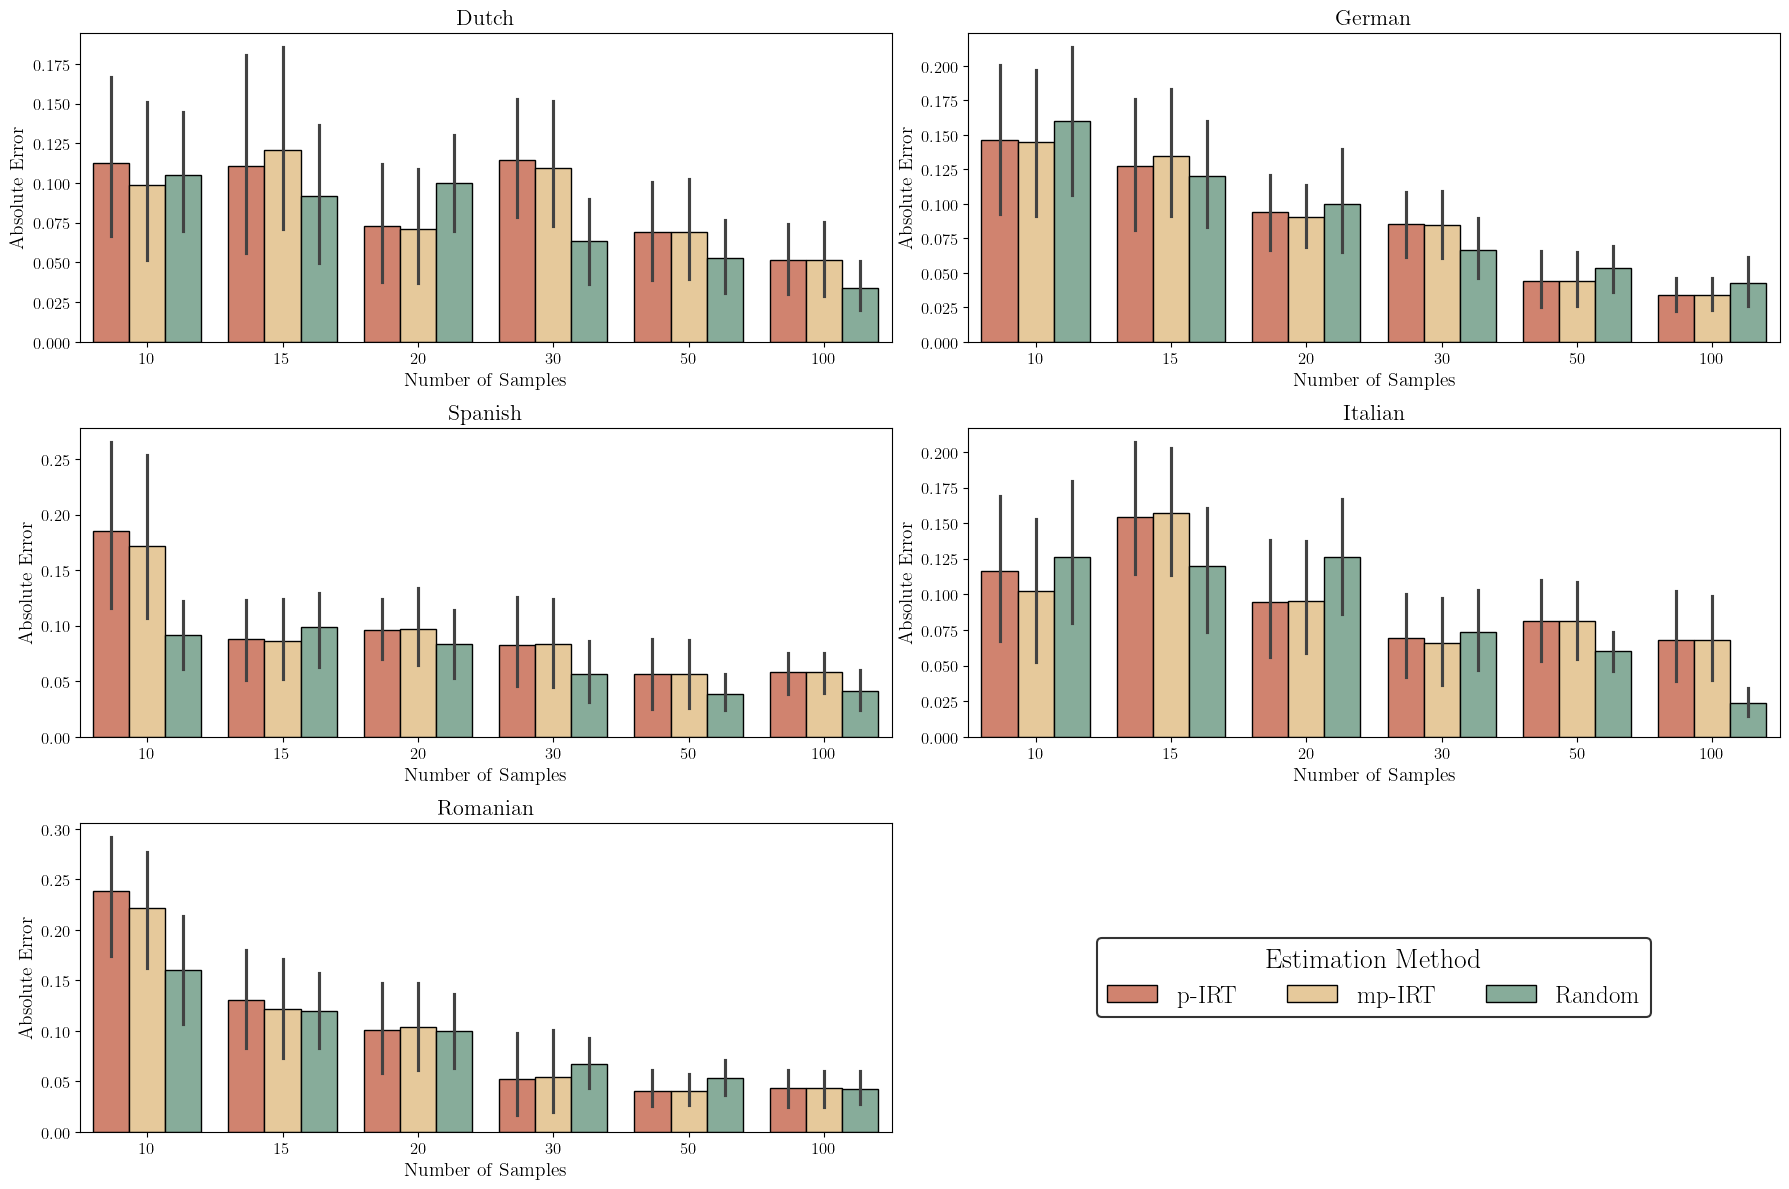

In [9]:
# Create a 3x2 layout of subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 12))  # 3 rows and 2 columns
axes = axes.flatten()  # Flatten the 2D array to easily iterate over it

# Define colors for the different estimate_methods of methods

# Iterate through each language and subplot axis
for i, lang in enumerate(langs):
    # Filter data for the specific language
    lang_data = estimated_acc_df[estimated_acc_df['lang'] == lang].copy()

    # Sort the data by hue_order to match the order of bars in the plot
    lang_data['estimate_method'] = pd.Categorical(lang_data['estimate_method'], categories=hue_order, ordered=True)
    lang_data = lang_data.sort_values('estimate_method')

    # Plot on the corresponding axis
    sns.barplot(
        x='n_samples', y='diff', hue='estimate_method', data=lang_data,
        palette=palette, hue_order=hue_order, edgecolor='black', linewidth=1., ax=axes[i])

    # Set the title for each subplot
    axes[i].set_title(f"{lang}".casefold().capitalize())

    # set font size for title
    axes[i].title.set_fontsize(16)

    # hide legend
    axes[i].get_legend().remove()

    # set y title to 'Absolute Error'
    axes[i].set_ylabel('Absolute Error')

    # set x title to 'Number of Samples'
    axes[i].set_xlabel('Number of Samples')

    # set font size for x and y labels
    axes[i].xaxis.label.set_fontsize(14)
    axes[i].yaxis.label.set_fontsize(14)

    # set font size for x and y ticks
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

# Add the legend to the last subplot
axes[-1].axis('off')  # Turn off the axis for the empty subplot
handles, labels = axes[0].get_legend_handles_labels()  # Get handles and labels from the first subplot

# Increase legend size by adjusting font size and label spacing
legend = axes[-1].legend(handles, labels, title='Estimation Method', loc='center', ncol=4, fontsize=18, title_fontsize=20)

# Optionally, increase the border and shadow of the legend for better visibility
legend.get_frame().set_alpha(0.8)  # Set transparency
legend.get_frame().set_linewidth(1.5)  # Set border linewidth
legend.get_frame().set_edgecolor('black')  # Set border color

# Adjust layout for better spacing
plt.tight_layout()

# Show the full plot
plt.show()